In [1]:
from holisticai.utils.trade_off_analysers import Fairea

In [2]:
import numpy as np
from holisticai.datasets import load_dataset

# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

# Dataset
dataset = load_dataset('adult', protected_attribute='sex')
dataset = dataset.rename({"x":"X"})
dataset = dataset.train_test_split(test_size=0.2, random_state=0)
dataset

DatasetDict({
    train: Dataset({
        features: ['X', 'y', 'group_a', 'group_b'],
        num_rows: 36177
    }),
    test: Dataset({
        features: ['X', 'y', 'group_a', 'group_b'],
        num_rows: 9045
    })
})

In [3]:
train_data = dataset['train']
test_data = dataset['test']

## Begin trade-off analysis with Fairea

In [4]:
fairea = Fairea(acc_metric='acc', fair_metric='aod', verbose=True)

### Create baseline and plot it

The first step involves a baseline construction. This is done by fitting a simple model which serves as a baseline, before the outputs are mutated to collect a set of trade-off points that will be used later to determine the mitigation regions for the model comparison. 

In [5]:
fairea.create_baseline(train_data['X'], train_data['y'], train_data['group_a'], train_data['group_b'])

<Axes: title={'center': 'Baseline Model'}, xlabel='Fairness', ylabel='Accuracy'>

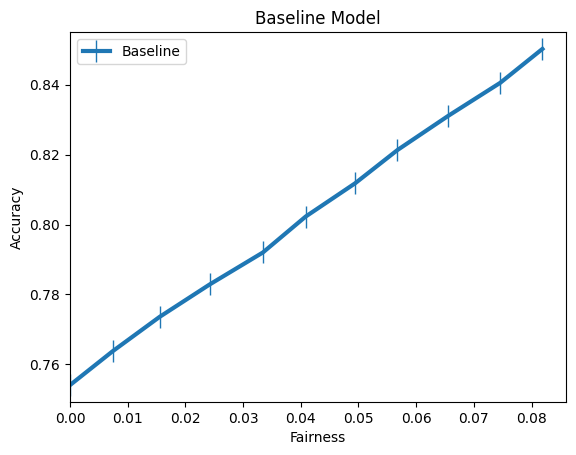

In [6]:
fairea.plot_baseline(title="Baseline Model", normalize=False)

### Add mitigation methods to the fairea object

In [7]:
# Preprocessing methods
from holisticai.bias.mitigation import CorrelationRemover

# Postprocessing methods
from holisticai.bias.mitigation import CalibratedEqualizedOdds

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [8]:
from holisticai.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", LogisticRegression()),
    ]
)

fit_params = {
    "bm__group_a": train_data['group_a'], 
    "bm__group_b": train_data['group_b']
}

pipeline.fit(train_data['X'], train_data['y'], **fit_params)

predict_params = {
    "bm__group_a": test_data['group_a'],
    "bm__group_b": test_data['group_b'],
}
y_pred = pipeline.predict(test_data['X'], **predict_params)

In [9]:
fairea.add_model_outcomes("CorrelationRemover", test_data['y'], y_pred, test_data['group_a'], test_data['group_b'])

In [10]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("estimator", LogisticRegression()),
        ("bm_postprocessing", CalibratedEqualizedOdds(cost_constraint="fnr")),
    ]
)

fit_params = {
    "bm__group_a": train_data['group_a'], 
    "bm__group_b": train_data['group_b']
}

pipeline.fit(train_data['X'], train_data['y'], **fit_params)

predict_params = {
    "bm__group_a": test_data['group_a'],
    "bm__group_b": test_data['group_b'],
}
y_pred = pipeline.predict(test_data['X'], **predict_params)

In [11]:
fairea.add_model_outcomes("CalibratedEqualizedOdds", test_data['y'], y_pred, test_data['group_a'], test_data['group_b'])

Let's plot the baseline and the trade-off points for the trade-off analysis.

<Axes: title={'center': 'Baseline Model with Mitigators'}, xlabel='Fairness', ylabel='Accuracy'>

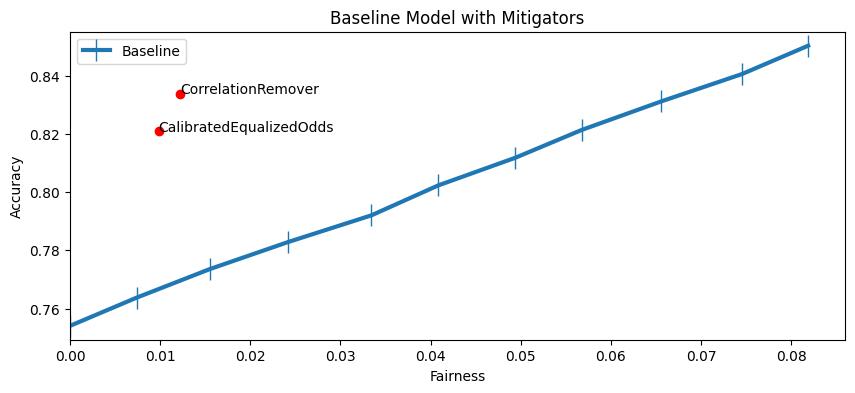

In [12]:
fairea.plot_methods(title="Baseline Model with Mitigators", normalize=False, figsize=(10, 4))

### Determine the region for the methods

Once the baseline has been created, and the mitigation methods have been added, the approach categorises the mitigator models into five regions that represent the effectiveness of the bias mitigation. These regions are:

- "Win-win": when a method improves the accuracy and reduces bias with respect to the original model.
- "Lose-lose": when a method reduces the accuracy and increases bias with respect to the original model.
- "Inverted trade-off": When a method improves accuracy but increases bias.
- "Good trade-off": when a method reduces bias and decreases accuracy but achieves a better trade-off than the baseline.
- "Poor trade-off": When a method reduces bias and decreases accuracy but achieves a lower trade-off than the baseline.

In [13]:
fairea.trade_off_region_classification()

,Region
CorrelationRemover,good trade-off
CalibratedEqualizedOdds,good trade-off


By default, the `trade_off_region_classification` method returns a dataframe with the trade-off regions for each method. But you can also plot the trade-off regions setting the `plot` parameter to `True`.

<Axes: >

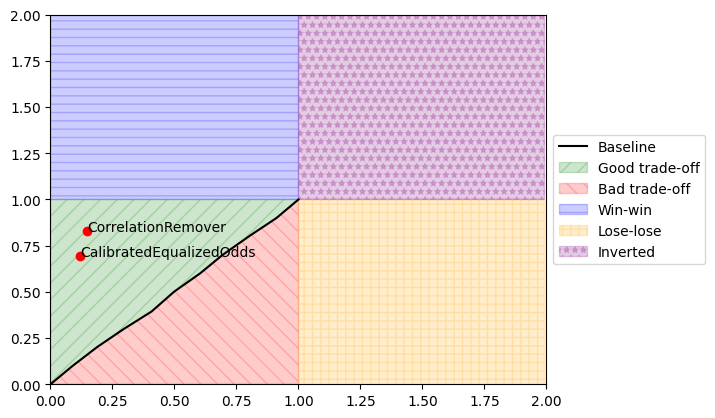

In [14]:
fairea.trade_off_region_classification(plot=True)

### Calculate area for "good trade-off" methods

After the mitigators have been categorised, the effectiveness of the methods is measured. Given that the win-win, lose-lose, inverted trade-off and the poor trade-off regions provide clear signals about how the mitigator performs, this measurement is focused on the mitigators that fall into the good trade-off region.

This is achieved by calculating the area that results by projecting a horizontal and a vertical line from the mitigator position to the trade-off points of the baseline. This area represents the strength of the fairness-accuracy trade-off. Therefore, the larger the area is, the better the fairness-accuracy trade-off.

In [15]:
fairea.compute_trade_off_area()

,Area
CorrelationRemover,0.230894
CalibratedEqualizedOdds,0.165802


### Get best model

As we can see, the model that presents a better trade-off is the Correlation Remover method, since it presents a larger area in comparison with the Calibrated Equalized odds method.

In [16]:
fairea.get_best_model()

'CorrelationRemover'